# Fate/Grand Order Servants Dataset Analysis and Visualization

### Data Download

In [28]:
import requests

url = "https://api.atlasacademy.io/export/JP/nice_servant_lore_lang_en.json"

res = requests.request("GET", url)

rawData: list[dict] = res.json()

for s in rawData:
    s['traits'] = list(map(lambda x: x['name'], s['traits']))
    s['saberface'] = 'saberface' in s['traits']

f"There are {len(rawData)} servants with these columns: {list(rawData[0].keys())}"

"There are 385 servants with these columns: ['id', 'collectionNo', 'name', 'originalName', 'ruby', 'battleName', 'originalBattleName', 'classId', 'className', 'type', 'flag', 'rarity', 'cost', 'lvMax', 'extraAssets', 'gender', 'attribute', 'traits', 'starAbsorb', 'starGen', 'instantDeathChance', 'cards', 'hitsDistribution', 'cardDetails', 'atkBase', 'atkMax', 'hpBase', 'hpMax', 'relateQuestIds', 'trialQuestIds', 'growthCurve', 'atkGrowth', 'hpGrowth', 'bondGrowth', 'expGrowth', 'expFeed', 'bondEquip', 'valentineEquip', 'valentineScript', 'ascensionAdd', 'traitAdd', 'svtChange', 'ascensionImage', 'ascensionMaterials', 'skillMaterials', 'appendSkillMaterials', 'costumeMaterials', 'coin', 'script', 'skills', 'classPassive', 'extraPassive', 'appendPassive', 'noblePhantasms', 'profile', 'saberface']"

### Data Cleaning

Some columns are not useful for the analysis so needs to be removed to improve performances


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.DataFrame(rawData)

df['illustrator'] = df['profile'].map(lambda x: x['illustrator'])
df = df[df["type"] != 'enemyCollectionDetail']

cleanData = df.drop(columns=[
    'ruby',
    'originalBattleName',
    'originalName',
    'classId',
    'cost',
    'lvMax',
    'extraAssets',
    'starAbsorb',
    'starGen',
    'instantDeathChance',
    'cardDetails',
    'relateQuestIds',
    'trialQuestIds',
    'valentineEquip',
    'valentineScript',
    'ascensionAdd',
    'traitAdd',
    'svtChange',
    'ascensionImage',
    'coin',
    'script',
    'profile'
])

cleanData.filter(items=['name', 'className', 'type', 'rarity', 'gender', 'traits' 'illustrator'])

,name,className,type,rarity,gender
0,Altria Pendragon,saber,normal,5,female
1,Altria Pendragon (Alter),saber,normal,4,female
2,Altria Pendragon (Lily),saber,normal,4,female
3,Nero Claudius,saber,normal,4,female
4,Nero Claudius (Bride),saber,normal,5,female
...,...,...,...,...,...
374,Hephaestion,pretender,normal,4,female
375,Lady Avalon,pretender,normal,5,female
376,Nine-Tattoo Dragon Eliza,pretender,normal,4,female
377,Tenochtitlan,pretender,normal,4,female


### Data Caching

In [30]:
cleanData.to_json("dataset.json", indent=1)

In [31]:
def configure(title, x_label, y_label, legend = None, grid = False):
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if legend:
        plt.legend(legend)
    if grid:
        plt.grid()

### Servants per Class

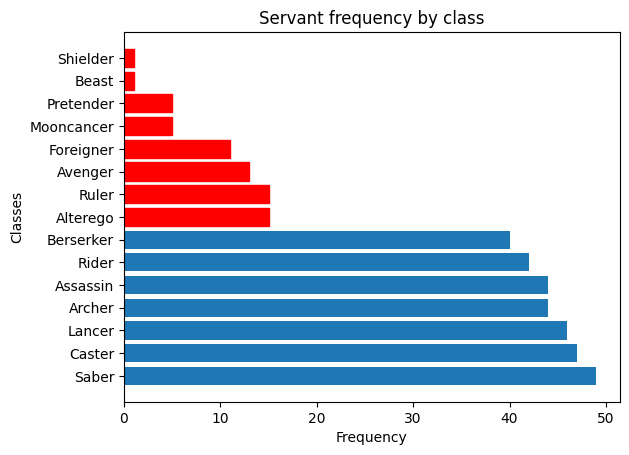

In [32]:
servants_per_class = df.groupby("className").count().sort_values(by="id", ascending=False)["id"]
classes = list(map(lambda x: x.title(), servants_per_class.keys()))
values = servants_per_class.values
bars = plt.barh(classes, values)
for b in bars[7:]:
    b.set_color('r')
configure("Servant frequency by class", "Frequency", "Classes")
plt.show()

# Griglia, colori diversi per classi extra, capire cosa fare con le mono (aggregarle?), numeri precisi a fine colonna, idee qui: https://www.geeksforgeeks.org/bar-plot-in-matplotlib/

### Servants by attribute

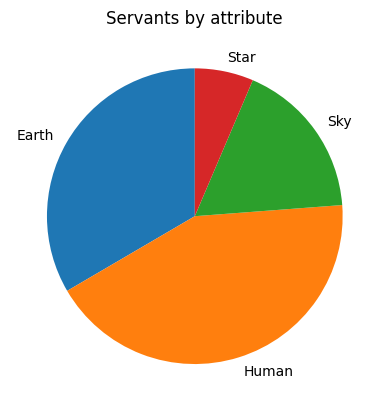

In [34]:
servants_by_attribute = cleanData[cleanData['attribute'] != "beast"].groupby('attribute').count()
plt.pie(servants_by_attribute["id"].values, labels=list(map(lambda x: x.title(),servants_by_attribute["id"].keys())), startangle = 90)
plt.title("Servants by attribute")
plt.show()

## Statistics by rarity

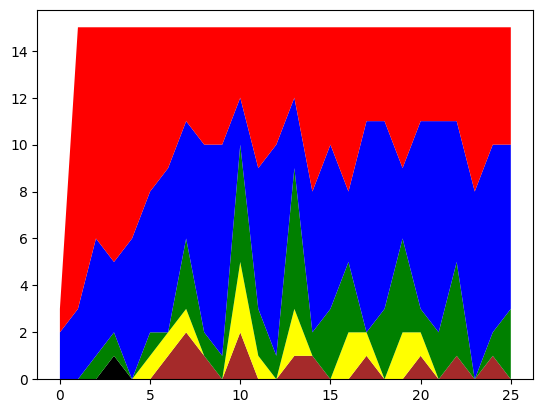

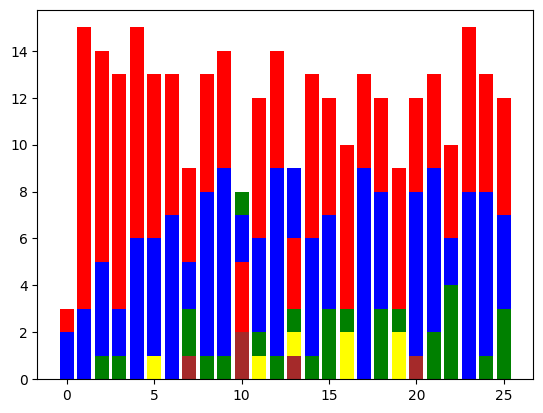

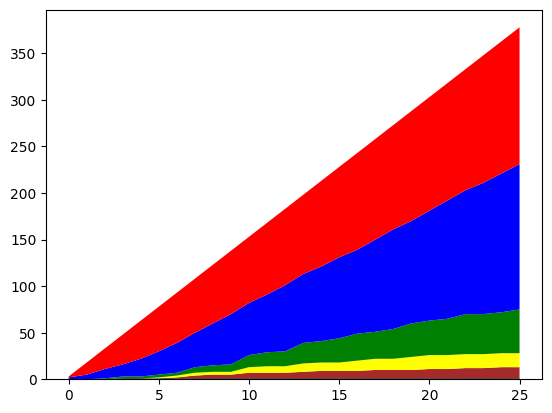

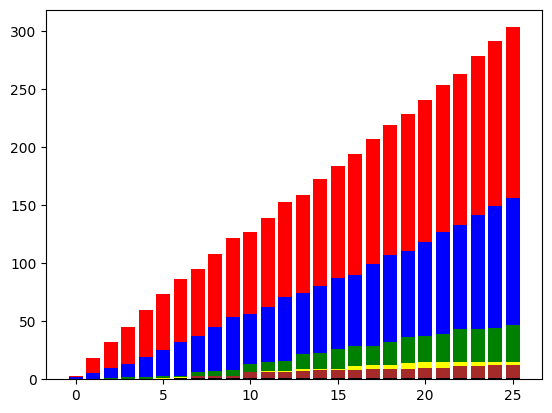

In [35]:
ssr_color = 'red'
sr_color = 'blue'
r_color = 'green'
b2_color = 'yellow'
b1_color = 'brown'
b0_color = 'black'

years = 8
blocks_per_year = 3

n = len(cleanData) // (blocks_per_year*years)
blocks = [cleanData[i:i+n] for i in range(0, len(cleanData),n)]

empty = pd.DataFrame({"rarity":[0,1,2,3,4,5],"id":[0,0,0,0,0,0]}).set_index("rarity")

groups = [list(i.groupby("rarity").count().filter(["id"]).add(empty, fill_value=0).values) for i in blocks]

groups.reverse()

x = range(0, len(blocks))
y = groups[0]
for i in groups[1:]:
    y = np.concatenate((y, i), axis=1)

plt.stackplot(x, y, labels=["0", "1", "2", "3", "4", "5"], colors=[b0_color, b1_color, b2_color, r_color, sr_color, ssr_color])
plt.show()

plt.bar(x, y[0], color=b0_color)
plt.bar(x, y[1], bottom=y[0], color=b1_color)
plt.bar(x, y[2], bottom=y[1], color=b2_color)
plt.bar(x, y[3], bottom=y[2], color=r_color)
plt.bar(x, y[4], bottom=y[3], color=sr_color)
plt.bar(x, y[5], bottom=y[4], color=ssr_color)
plt.show()

y = y.cumsum(axis = 1)

plt.stackplot(x, y, labels=["0", "1", "2", "3", "4", "5"], colors=[b0_color, b1_color, b2_color, r_color, sr_color, ssr_color])
plt.show()

plt.bar(x, y[0], color=b0_color)
plt.bar(x, y[1], bottom=y[0], color=b1_color)
plt.bar(x, y[2], bottom=y[1], color=b2_color)
plt.bar(x, y[3], bottom=y[2], color=r_color)
plt.bar(x, y[4], bottom=y[3], color=sr_color)
plt.bar(x, y[5], bottom=y[4], color=ssr_color)
plt.show()

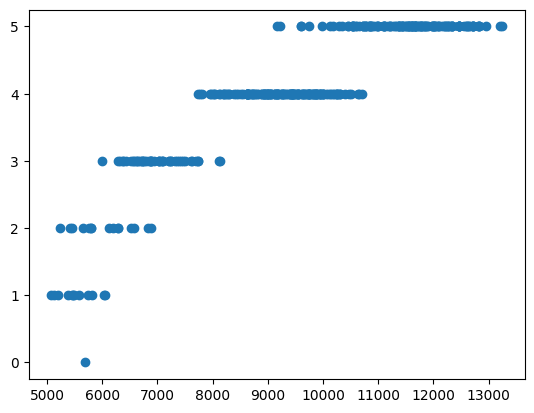

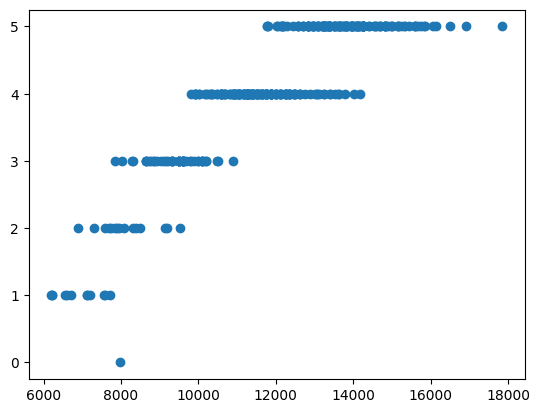

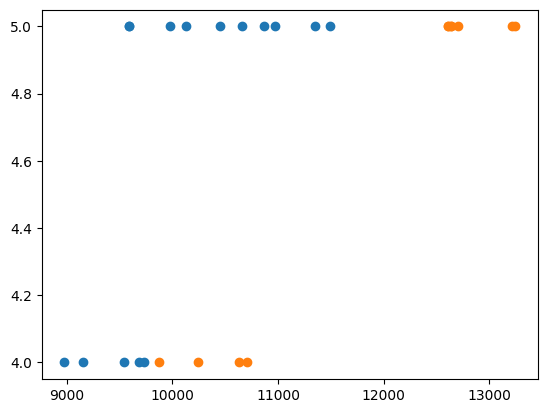

In [36]:
# Confronto rarita' e statistiche
# Confronto classe e statistiche
servants_statistics_clean = cleanData[(cleanData["atkMax"] < 20000) &(cleanData["hpMax"] < 22000)]
plt.scatter(servants_statistics_clean["atkMax"].values, servants_statistics_clean["rarity"].values)
plt.show()

plt.scatter(servants_statistics_clean["hpMax"].values, servants_statistics_clean["rarity"].values)
plt.show()

# Ruler vs Avenger in hp e danni, da rivedere
servants_ruler = servants_statistics_clean[(servants_statistics_clean["className"] == 'ruler') & (servants_statistics_clean["rarity"] > 3)]
servants_avenger = servants_statistics_clean[(servants_statistics_clean["className"] == 'avenger') & (servants_statistics_clean["rarity"] > 3)]
plt.scatter(servants_ruler["atkMax"].values, servants_ruler["rarity"].values)
plt.scatter(servants_avenger["atkMax"].values, servants_avenger["rarity"].values)
plt.show()

In [37]:
# NP type (danno o meno) e correlazione con l'essere caster

### Statistics Growth


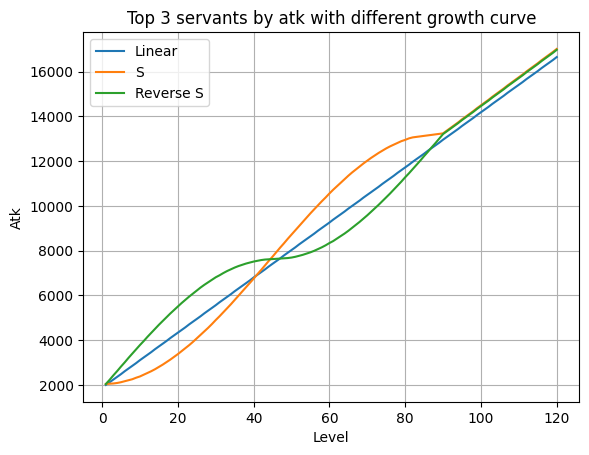

In [46]:
linear_growth = cleanData.loc[(cleanData['name'] == "Ibuki-Douji") & (cleanData['className'] == "berserker")].filter(["atkGrowth"]).values[0][0]
s_growth = cleanData.loc[(cleanData['name'] == "Jeanne d'Arc (Alter)") & (cleanData['className'] == "avenger")].filter(["atkGrowth"]).values[0][0]
reverse_s_growth = cleanData.loc[(cleanData['name'] == "Kama") & (cleanData['className'] == "avenger")].filter(["atkGrowth"]).values[0][0]

plt.plot(list(range(1, len(linear_growth)+1)), linear_growth)
plt.plot(list(range(1, len(s_growth)+1)), s_growth)
plt.plot(list(range(1, len(reverse_s_growth)+1)), reverse_s_growth)
configure("Top 3 servants by atk with different growth curve", "Level","Atk", legend=["Linear", "S", "Reverse S"], grid=True)
plt.show()

### Classes with the best and worst statistics

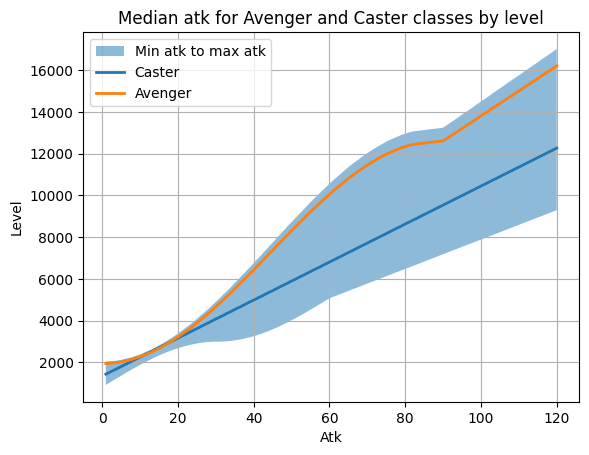

In [52]:
max_atk_growth = cleanData[cleanData["atkMax"] == cleanData["atkMax"].max()].filter(["atkGrowth"]).values[0][0]# cleanData.loc[(['name'] == "Ibuki-Douji") & (cleanData['className'] == "berserker")].filter(["atkGrowth"]).values[0][0]
min_atk_growth = cleanData[cleanData["atkMax"] == cleanData["atkMax"].min()].filter(["atkGrowth"]).values[0][0]# cleanData.loc[(['name'] == "Ibuki-Douji") & (cleanData['className'] == "berserker")].filter(["atkGrowth"]).values[0][0]

casters = cleanData[cleanData["className"] == "caster"]
caster_average_growth = casters[casters["atkMax"] == casters["atkMax"].median()].iloc[0].filter(["atkGrowth"]).values[0]
avengers = cleanData[cleanData["className"] == "avenger"]
avenger_average_growth = avengers[avengers["atkMax"] == avengers["atkMax"].median()].iloc[0].filter(["atkGrowth"]).values[0]


to_120 = range(1, 120+1)

fig, ax = plt.subplots()
ax.fill_between(to_120, min_atk_growth, max_atk_growth, alpha=.5, linewidth=0)
ax.plot(to_120, caster_average_growth, linewidth=2)
ax.plot(to_120, avenger_average_growth, linewidth=2)
configure("Median atk for Avenger and Caster classes by level", "Atk","Level", legend=["Min atk to max atk", "Caster", "Avenger"], grid=True)
plt.show()

### Servants by illustrator

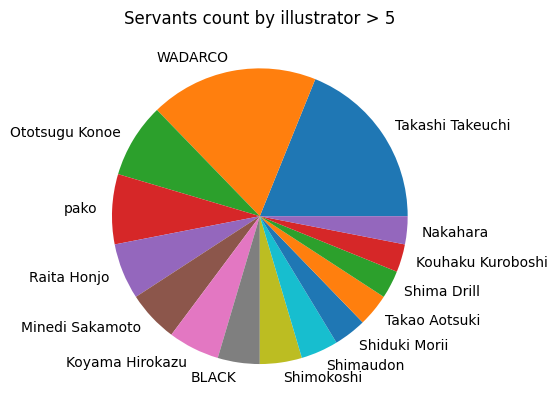

In [40]:
servants_by_illustrator = cleanData.groupby(by='illustrator').count().sort_values(by="id", ascending=False)["id"]
servants_by_illustrator  = servants_by_illustrator[servants_by_illustrator > 5]
illustrators = list(servants_by_illustrator.keys())
values = servants_by_illustrator.values
plt.pie(values,labels=illustrators)
plt.title("Servants count by illustrator > 5")
plt.show()

### Servants illustrated by Takeuchi by the presence of the "saberface" trait

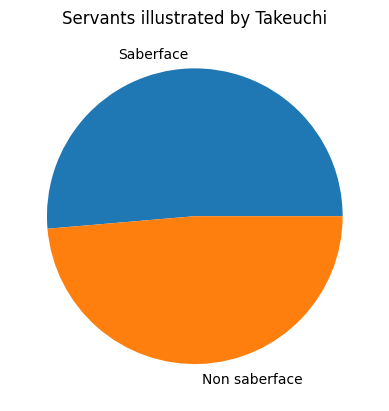

In [41]:
servants_by_take = cleanData[cleanData["illustrator"] == "Takashi Takeuchi"].copy()
servants_by_take = servants_by_take.groupby(by='saberface').count().sort_values(by="id", ascending=False)
values = servants_by_take["id"].values
plt.pie(values,labels=["Saberface", "Non saberface"])
plt.title("Servants illustrated by Takeuchi")
plt.show() #renderlo a barre e far vedere la distribuzione totale vs quella di take

Servants illustrated by WADARCO by class being extra or not

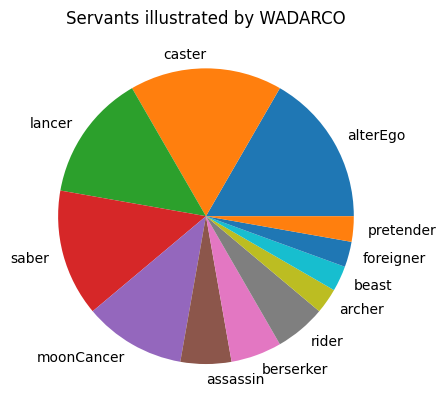

In [42]:
servants_by_wada = cleanData[cleanData["illustrator"] == "WADARCO"].copy()
servants_by_wada = servants_by_wada.groupby(by='className').count().sort_values(by="id", ascending=False)
values = servants_by_wada["id"].values
plt.pie(values,labels=servants_by_wada["id"].keys())
plt.title("Servants illustrated by WADARCO")
plt.show()